# Phase 1

In [132]:
# Install only once at the top
!pip install -q kagglehub[pandas-datasets]


In [133]:
from pathlib import Path
import kagglehub

# Download dataset
BASE_ROOT = kagglehub.dataset_download("xdxd003/ff-c23")
BASE_ROOT = Path(BASE_ROOT)

# ✅ Actual FF++ root
DATA_ROOT = BASE_ROOT / "FaceForensics++_C23"

print("Corrected DATA_ROOT:", DATA_ROOT)
print("Folders:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])


Using Colab cache for faster access to the 'ff-c23' dataset.
Corrected DATA_ROOT: /kaggle/input/ff-c23/FaceForensics++_C23
Folders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']


In [134]:
import pandas as pd

video_index = []

# REAL videos
for vid in (DATA_ROOT / "original").glob("*.mp4"):
    video_index.append({
        "video_path": str(vid),
        "label": "real",
        "manipulation": "original",
        "identity": vid.stem
    })

# FAKE videos
manipulation_folders = [
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures"
]

for manip in manipulation_folders:
    for vid in (DATA_ROOT / manip).glob("*.mp4"):
        identity = vid.stem.split("_")[0]   # FF++ identity convention
        video_index.append({
            "video_path": str(vid),
            "label": "fake",
            "manipulation": manip,
            "identity": identity
        })

videos_df = pd.DataFrame(video_index)
videos_df.head()


,video_path,label,manipulation,identity
0,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,123
1,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,738
2,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,479
3,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,660
4,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,565


In [135]:
print("Total videos:", len(videos_df))
print("\nLabel distribution:")
print(videos_df["label"].value_counts())

print("\nManipulation distribution:")
print(videos_df["manipulation"].value_counts())

print("\nUnique identities:", videos_df["identity"].nunique())


Total videos: 7000

Label distribution:
label
fake    6000
real    1000
Name: count, dtype: int64

Manipulation distribution:
manipulation
original             1000
DeepFakeDetection    1000
Deepfakes            1000
Face2Face            1000
FaceShifter          1000
FaceSwap             1000
NeuralTextures       1000
Name: count, dtype: int64

Unique identities: 1028


In [136]:
import random

random.seed(42)

identities = videos_df["identity"].unique().tolist()
random.shuffle(identities)

n = len(identities)
train_ids = identities[:int(0.6 * n)]
val_ids   = identities[int(0.6 * n):int(0.8 * n)]
test_ids  = identities[int(0.8 * n):]

train_df = videos_df[videos_df["identity"].isin(train_ids)]
val_df   = videos_df[videos_df["identity"].isin(val_ids)]
test_df  = videos_df[videos_df["identity"].isin(test_ids)]

# Safety checks
assert set(train_ids).isdisjoint(val_ids)
assert set(train_ids).isdisjoint(test_ids)
assert set(val_ids).isdisjoint(test_ids)

print("✅ Identity-disjoint splits verified")
print("Train videos:", len(train_df))
print("Val videos  :", len(val_df))
print("Test videos :", len(test_df))


✅ Identity-disjoint splits verified
Train videos: 4038
Val videos  : 1418
Test videos : 1544


In [137]:
from collections import defaultdict

def build_task_pools(df):
    tasks = defaultdict(list)
    for _, row in df.iterrows():
        task_name = f"FFPP_{row['manipulation']}"
        tasks[task_name].append({
            "video_path": row["video_path"],
            "label": row["label"],
            "identity": row["identity"]
        })
    return tasks

meta_train_tasks = build_task_pools(train_df)
meta_val_tasks   = build_task_pools(val_df)
meta_test_tasks  = build_task_pools(test_df)

print("Meta-train tasks:", meta_train_tasks.keys())


Meta-train tasks: dict_keys(['FFPP_original', 'FFPP_DeepFakeDetection', 'FFPP_Deepfakes', 'FFPP_Face2Face', 'FFPP_FaceShifter', 'FFPP_FaceSwap', 'FFPP_NeuralTextures'])


In [138]:
import json

PHASE1_OUT = Path("/content/phase1_tasks/ffpp")
PHASE1_OUT.mkdir(parents=True, exist_ok=True)

with open(PHASE1_OUT / "meta_train_tasks.json", "w") as f:
    json.dump(meta_train_tasks, f, indent=2)

with open(PHASE1_OUT / "meta_val_tasks.json", "w") as f:
    json.dump(meta_val_tasks, f, indent=2)

with open(PHASE1_OUT / "meta_test_tasks.json", "w") as f:
    json.dump(meta_test_tasks, f, indent=2)

print("✅ Phase 1 task files saved at:", PHASE1_OUT)


✅ Phase 1 task files saved at: /content/phase1_tasks/ffpp


# Phase 2.1

 > Restart session after the below installations


In [8]:
!pip install -U opencv-python-headless facenet-pytorch torch torchvision pillow


  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.


In [9]:
import json
import cv2
import numpy as np
import torch
import torchvision.models as models
from facenet_pytorch import MTCNN, extract_face
from pathlib import Path
from PIL import Image


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [11]:
PHASE1_ROOT = Path("/content/phase1_tasks/ffpp")

json_files = [
    PHASE1_ROOT / "meta_train_tasks.json",
    PHASE1_ROOT / "meta_val_tasks.json",
    PHASE1_ROOT / "meta_test_tasks.json",
]

videos = {}
for jf in json_files:
    with open(jf) as f:
        tasks = json.load(f)
        for _, vids in tasks.items():
            for v in vids:
                videos[v["video_path"]] = True

print("Unique videos found:", len(videos))


Unique videos found: 7000


In [12]:
import cv2
print("OpenCV version:", cv2.__version__)


OpenCV version: 4.13.0


In [13]:
def extract_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        cap.release()
        return []

    idxs = np.linspace(0, total - 1, num_frames, dtype=int)
    frames = []

    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames


In [14]:
mtcnn = MTCNN(
    select_largest=True,
    device=device
)

def extract_faces(frames):
    faces = []

    for frame in frames:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(rgb)

        boxes, _ = mtcnn.detect(img)
        if boxes is None:
            continue

        face = extract_face(
            img,
            boxes[0],
            image_size=224
        )  # torch.Tensor [3,224,224]

        faces.append(face)

    return faces


In [15]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Identity()
model = model.to(device).eval()

def embed_faces(faces):
    embeddings = []
    with torch.no_grad():
        for face in faces:
            emb = model(face.unsqueeze(0).to(device))
            embeddings.append(emb.cpu().numpy()[0])
    return embeddings


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [16]:
def aggregate_embeddings(embeddings):
    return np.mean(np.stack(embeddings), axis=0)


## code


In [63]:
import shutil
from pathlib import Path

FFPP_ROOT = Path("/content/data/processed/embeddings/ffpp")

if FFPP_ROOT.exists():
    shutil.rmtree(FFPP_ROOT)

FFPP_ROOT.mkdir(parents=True, exist_ok=True)

print("✅ FF++ embeddings folder reset")


✅ FF++ embeddings folder reset


In [19]:
# # ==============================
# # CELL 2: WITH TASK STRUCTURE + meta.json
# # ==============================

# import json
# import time
# import numpy as np
# from pathlib import Path

# NUM_FRAMES = 10
# MIN_FACES = 3
# MAX_VIDEOS_PER_TASK = 5   # set None for full run

# PHASE1_ROOT = Path("/content/phase1_tasks/ffpp")
# OUT_ROOT = Path("/content/data/processed/embeddings/ffpp")
# OUT_ROOT.mkdir(parents=True, exist_ok=True)

# # ---- load Phase 1 tasks ----
# with open(PHASE1_ROOT / "meta_train_tasks.json") as f:
#     tasks = json.load(f)

# # ---- Phase 2 task-wise loop ----
# for task_name, videos in tasks.items():

#     task_dir = OUT_ROOT / task_name
#     task_dir.mkdir(parents=True, exist_ok=True)

#     meta_dict = {}

#     if MAX_VIDEOS_PER_TASK is not None:
#         videos = videos[:MAX_VIDEOS_PER_TASK]

#     print(f"\n▶ Task: {task_name} | Videos: {len(videos)}")

#     for idx, v in enumerate(videos, 1):
#         video_path = v["video_path"]
#         video_id = Path(video_path).stem
#         t0 = time.time()

#         frames = extract_frames(video_path, num_frames=NUM_FRAMES)
#         if not frames:
#             continue

#         faces = extract_faces(frames)
#         if len(faces) < MIN_FACES:
#             continue

#         embs = embed_faces(faces)
#         video_emb = aggregate_embeddings(embs)

#         # ✅ Save ONLY embedding (correct way)
#         np.save(task_dir / f"{video_id}.npy", video_emb)

#         # ✅ Store metadata separately
#         meta_dict[f"{video_id}.npy"] = {
#             "label": v["label"],
#             "identity": v["identity"]
#         }

#         print(
#             f"[{idx}/{len(videos)}] {video_id} | "
#             f"faces={len(faces)} | "
#             f"time={time.time() - t0:.2f}s"
#         )

#     # ---- save meta.json per task ----
#     with open(task_dir / "meta.json", "w") as f:
#         json.dump(meta_dict, f, indent=2)



▶ Task: FFPP_original | Videos: 5
[1/5] 738 | faces=10 | time=11.83s
[2/5] 565 | faces=10 | time=4.90s
[3/5] 033 | faces=10 | time=5.56s
[4/5] 581 | faces=10 | time=11.72s
[5/5] 408 | faces=10 | time=2.80s

▶ Task: FFPP_DeepFakeDetection | Videos: 5
[1/5] 26_12__walking_down_street_outside_angry__OVOQACG8 | faces=10 | time=8.73s
[2/5] 15_06__exit_phone_room__E98QYYXO | faces=10 | time=5.41s
[3/5] 26_25__outside_talking_still_laughing__7ZRKCFMS | faces=10 | time=8.12s
[4/5] 15_03__podium_speech_happy__Y11NT1YX | faces=10 | time=8.09s
[5/5] 26_01__secret_conversation__BTVMWLG6 | faces=10 | time=10.00s

▶ Task: FFPP_Deepfakes | Videos: 5
[1/5] 315_322 | faces=10 | time=2.52s
[2/5] 645_688 | faces=10 | time=13.15s
[3/5] 700_813 | faces=10 | time=4.69s
[4/5] 313_283 | faces=10 | time=1.63s
[5/5] 336_338 | faces=10 | time=1.92s

▶ Task: FFPP_Face2Face | Videos: 5
[1/5] 315_322 | faces=10 | time=2.23s
[2/5] 645_688 | faces=10 | time=14.50s
[3/5] 700_813 | faces=10 | time=4.11s
[4/5] 313_283 

In [64]:
import json
import time
import numpy as np
from pathlib import Path

NUM_FRAMES = 10
MIN_FACES = 3
MAX_VIDEOS_PER_TASK = 10
ORIGINAL_LIMIT = 60   # 🔥 60 videos for FFPP_original

PHASE1_ROOT = Path("/content/phase1_tasks/ffpp")
OUT_ROOT = Path("/content/data/processed/embeddings/ffpp")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# ---- load Phase 1 tasks ----
with open(PHASE1_ROOT / "meta_train_tasks.json") as f:
    tasks = json.load(f)

# ---- Phase 2 task-wise loop ----
for task_name, videos in tasks.items():

    task_dir = OUT_ROOT / task_name
    task_dir.mkdir(parents=True, exist_ok=True)

    meta_dict = {}

    # 🔥 Special rule for FFPP_original
    if task_name == "FFPP_original":
        selected_videos = videos[:ORIGINAL_LIMIT]
    else:
        selected_videos = videos[:MAX_VIDEOS_PER_TASK]

    print(f"\n▶ Task: {task_name} | Videos: {len(selected_videos)}")

    for idx, v in enumerate(selected_videos, 1):

        video_path = v["video_path"]
        video_id = Path(video_path).stem
        t0 = time.time()

        frames = extract_frames(video_path, num_frames=NUM_FRAMES)
        if not frames:
            continue

        faces = extract_faces(frames)
        if len(faces) < MIN_FACES:
            continue

        embs = embed_faces(faces)
        video_emb = aggregate_embeddings(embs)

        np.save(task_dir / f"{video_id}.npy", video_emb)

        meta_dict[f"{video_id}.npy"] = {
            "label": v["label"],
            "identity": v["identity"]
        }

        print(
            f"[{idx}/{len(selected_videos)}] {video_id} | "
            f"faces={len(faces)} | "
            f"time={time.time() - t0:.2f}s"
        )

    # ---- save meta.json per task ----
    with open(task_dir / "meta.json", "w") as f:
        json.dump(meta_dict, f, indent=2)



▶ Task: FFPP_original | Videos: 60
[1/60] 738 | faces=10 | time=5.11s
[2/60] 565 | faces=10 | time=1.86s
[3/60] 033 | faces=10 | time=2.02s
[4/60] 581 | faces=10 | time=11.63s
[5/60] 408 | faces=10 | time=2.65s
[6/60] 312 | faces=10 | time=1.77s
[7/60] 929 | faces=10 | time=2.00s
[8/60] 324 | faces=10 | time=2.49s
[9/60] 113 | faces=10 | time=4.43s
[10/60] 989 | faces=10 | time=2.03s
[11/60] 668 | faces=10 | time=2.22s
[12/60] 491 | faces=10 | time=9.95s
[13/60] 227 | faces=10 | time=4.07s
[14/60] 357 | faces=10 | time=2.29s
[15/60] 127 | faces=10 | time=3.84s
[16/60] 106 | faces=10 | time=1.62s
[17/60] 731 | faces=10 | time=1.62s
[18/60] 258 | faces=10 | time=6.67s
[19/60] 019 | faces=10 | time=1.67s
[20/60] 714 | faces=10 | time=4.85s
[21/60] 017 | faces=10 | time=5.16s
[22/60] 957 | faces=10 | time=11.55s
[23/60] 765 | faces=10 | time=1.83s
[24/60] 299 | faces=10 | time=1.90s
[25/60] 424 | faces=10 | time=1.55s
[26/60] 743 | faces=10 | time=4.07s
[27/60] 648 | faces=10 | time=4.96s

In [65]:
import matplotlib.pyplot as plt
import cv2

def show_phase2_input_output(video_path):
    # ---- extract ONE frame ----
    frames = extract_frames(video_path, num_frames=1)
    if not frames:
        print("No frame extracted")
        return

    frame = frames[0]

    # ---- detect face ----
    faces = extract_faces([frame])
    face = faces[0] if faces else None

    plt.figure(figsize=(10, 4))

    # INPUT
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Input: Video Frame")
    plt.axis("off")

    # OUTPUT
    plt.subplot(1, 2, 2)
    if face is not None:
        face_img = face.permute(1, 2, 0).cpu().numpy()
        face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
        plt.imshow(face_img)
        plt.title("Output: Face Crop (224×224)")
    else:
        plt.text(0.5, 0.5, "No Face Detected", ha="center", va="center")
        plt.title("Output: No Face")

    plt.axis("off")
    plt.show()


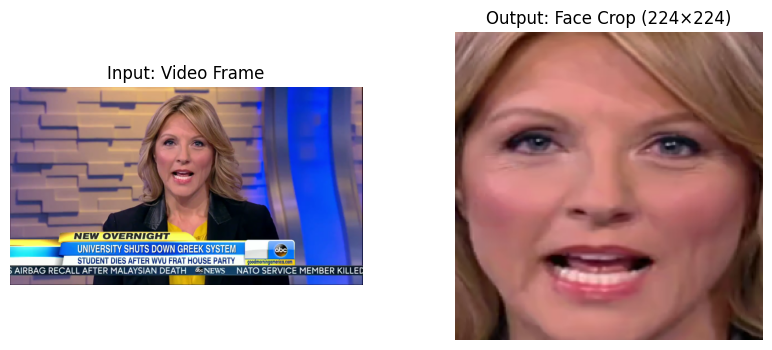

In [66]:

example_task = list(tasks.keys())[0]
example_video = tasks[example_task][0]["video_path"]

show_phase2_input_output(example_video)


In [22]:
# ========================================================

# Phase 3


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm


In [68]:
def load_dataset(root_dir):
    X = []
    y = []

    root_dir = Path(root_dir)

    for task_dir in root_dir.iterdir():
        if not task_dir.is_dir():
            continue

        meta_path = task_dir / "meta.json"
        if not meta_path.exists():
            continue

        with open(meta_path) as f:
            meta = json.load(f)

        for fname, info in meta.items():
            emb_path = task_dir / fname
            if not emb_path.exists():
                continue

            emb = np.load(emb_path)
            label = 1 if info["label"] == "fake" else 0

            X.append(emb)
            y.append(label)

    return np.array(X), np.array(y)


In [69]:
FFPP_ROOT = "/content/data/processed/embeddings/ffpp"

X_ffpp, y_ffpp = load_dataset(FFPP_ROOT)

print("FF++ samples:", len(X_ffpp))
print("Embedding shape:", X_ffpp.shape)


FF++ samples: 120
Embedding shape: (120, 512)


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_ffpp, y_ffpp, test_size=0.2, random_state=42, stratify=y_ffpp
)


In [71]:
class BaselineClassifier(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)


In [72]:
# TRAINING LOOP

device = "cuda" if torch.cuda.is_available() else "cpu"

model = BaselineClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss.item():.4f}")


Epoch [1/20] Loss: 20.5680
Epoch [2/20] Loss: 16.4437
Epoch [3/20] Loss: 12.3194
Epoch [4/20] Loss: 8.1955
Epoch [5/20] Loss: 4.0850
Epoch [6/20] Loss: 1.1737
Epoch [7/20] Loss: 4.2124
Epoch [8/20] Loss: 6.2005
Epoch [9/20] Loss: 6.7877
Epoch [10/20] Loss: 6.3561
Epoch [11/20] Loss: 5.1548
Epoch [12/20] Loss: 3.3629
Epoch [13/20] Loss: 1.4027
Epoch [14/20] Loss: 1.4715
Epoch [15/20] Loss: 2.7083
Epoch [16/20] Loss: 3.5109
Epoch [17/20] Loss: 3.7376
Epoch [18/20] Loss: 3.4557
Epoch [19/20] Loss: 2.7481
Epoch [20/20] Loss: 1.7668


In [78]:
def evaluate(model, X, y):
    model.eval()

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    preds = (probs > 0.5).astype(int)

    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, probs)

    return acc, f1, auc


In [79]:
# IN DOMAIN RESULTS

acc, f1, auc = evaluate(model, X_test, y_test)

print("\n📊 In-domain (FF++ → FF++)")
print("Accuracy:", round(acc, 4))
print("F1-score:", round(f1, 4))
print("AUC:", round(auc, 4))



📊 In-domain (FF++ → FF++)
Accuracy: 0.5417
F1-score: 0.3529
AUC: 0.5764


In [80]:
# STEP 1 — Download Celeb-DF

import kagglehub
from pathlib import Path

# Download dataset
BASE_ROOT = kagglehub.dataset_download("reubensuju/celeb-df-v2")
BASE_ROOT = Path(BASE_ROOT)

print("Dataset path:", BASE_ROOT)
print("Folders:", [p.name for p in BASE_ROOT.iterdir()])


Using Colab cache for faster access to the 'celeb-df-v2' dataset.
Dataset path: /kaggle/input/celeb-df-v2
Folders: ['YouTube-real', 'Celeb-synthesis', 'Celeb-real', 'List_of_testing_videos.txt']


In [81]:
# STEP 2 — Inspect Dataset Structure

for p in BASE_ROOT.iterdir():
    print(p)


/kaggle/input/celeb-df-v2/YouTube-real
/kaggle/input/celeb-df-v2/Celeb-synthesis
/kaggle/input/celeb-df-v2/Celeb-real
/kaggle/input/celeb-df-v2/List_of_testing_videos.txt


In [82]:
# Step 3 - Build Video Index (Celeb-DF)

video_index = []

# Real videos
for folder in ["Celeb-real", "YouTube-real"]:
    for vid in (BASE_ROOT / folder).glob("*.mp4"):
        video_index.append({
            "video_path": str(vid),
            "label": "real",
            "identity": vid.stem
        })

# Fake videos
for vid in (BASE_ROOT / "Celeb-synthesis").glob("*.mp4"):
    video_index.append({
        "video_path": str(vid),
        "label": "fake",
        "identity": vid.stem
    })

print("Total Celeb-DF videos:", len(video_index))


Total Celeb-DF videos: 6529


In [83]:
# =========================================
# CELL: Define Feature Extractor (ResNet-18)
# Creates frozen 512-D embedding generator
# =========================================

import torch
import torchvision.models as models

# Select device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ResNet-18
feature_extractor = models.resnet18(weights="IMAGENET1K_V1")

# Remove final fully connected layer to get 512-D embeddings
feature_extractor.fc = torch.nn.Identity()

# Move model to device and set evaluation mode
feature_extractor = feature_extractor.to(device).eval()


In [84]:
# =========================================
# CELL: Update embed_faces() to Use Feature Extractor
# Generates frame-level 512-D embeddings
# =========================================

def embed_faces(faces):
    """
    Converts aligned face tensors into 512-D embeddings
    using the frozen ResNet-18 feature extractor.
    """
    embeddings = []

    # Disable gradient computation (inference mode)
    with torch.no_grad():
        for face in faces:
            face = face.to(device)                  # Move to GPU/CPU
            emb = feature_extractor(face.unsqueeze(0))  # Shape: [1, 512]
            embeddings.append(emb.cpu().numpy()[0])     # Store as numpy

    return embeddings


In [85]:
# =========================================
# CELL: Define Baseline Classifier
# Single-layer binary classifier (512 → 1)
# =========================================

import torch.nn as nn

class BaselineClassifier(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

# Initialize classifier
classifier = BaselineClassifier().to(device)


## class balanced

In [86]:
# =========================================
# CELL: Create Balanced Celeb-DF Subset
# Selects equal number of real and fake videos
# =========================================

import random

NUM_PER_CLASS = 25   # 25 real + 25 fake = 50 total

real_videos = [v for v in video_index if v["label"] == "real"]
fake_videos = [v for v in video_index if v["label"] == "fake"]

random.seed(42)
real_subset = random.sample(real_videos, min(NUM_PER_CLASS, len(real_videos)))
fake_subset = random.sample(fake_videos, min(NUM_PER_CLASS, len(fake_videos)))

video_index_subset = real_subset + fake_subset
random.shuffle(video_index_subset)

print("Real:", len(real_subset))
print("Fake:", len(fake_subset))
print("Total:", len(video_index_subset))


Real: 25
Fake: 25
Total: 50


In [88]:
# =========================================
# CELL: Delete Old Celeb-DF Embeddings
# Ensures clean regeneration of balanced subset
# =========================================

import shutil
from pathlib import Path

CELEB_ROOT = Path("/content/data/processed/embeddings/celebdf")

if CELEB_ROOT.exists():
    shutil.rmtree(CELEB_ROOT)

CELEB_ROOT.mkdir(parents=True, exist_ok=True)

print("✅ Clean Celeb-DF folder ready")


✅ Clean Celeb-DF folder ready


In [89]:
# =========================================
# CELL: Generate Celeb-DF Embeddings (50 Balanced Videos)
# Extracts embeddings for exactly 25 real + 25 fake videos
# =========================================

import random
import json
import time
import numpy as np
from pathlib import Path

NUM_FRAMES = 10
MIN_FACES = 3
NUM_PER_CLASS = 25   # 25 real + 25 fake = 50 total

CELEB_ROOT = Path("/content/data/processed/embeddings/celebdf")

# Reset folder
import shutil
if CELEB_ROOT.exists():
    shutil.rmtree(CELEB_ROOT)

CELEB_ROOT.mkdir(parents=True, exist_ok=True)

# Split videos by label
real_videos = [v for v in video_index if v["label"] == "real"]
fake_videos = [v for v in video_index if v["label"] == "fake"]

# Deterministic sampling
random.seed(42)
real_subset = random.sample(real_videos, min(NUM_PER_CLASS, len(real_videos)))
fake_subset = random.sample(fake_videos, min(NUM_PER_CLASS, len(fake_videos)))

selected_videos = real_subset + fake_subset
random.shuffle(selected_videos)

print("Selected Real:", len(real_subset))
print("Selected Fake:", len(fake_subset))
print("Total Selected:", len(selected_videos))

meta_dict = {}

# Generate embeddings
for idx, v in enumerate(selected_videos, 1):

    video_path = v["video_path"]
    video_id = Path(video_path).stem
    t0 = time.time()

    frames = extract_frames(video_path, num_frames=NUM_FRAMES)
    if not frames:
        continue

    faces = extract_faces(frames)
    if len(faces) < MIN_FACES:
        continue

    embs = embed_faces(faces)
    video_emb = aggregate_embeddings(embs)

    np.save(CELEB_ROOT / f"{video_id}.npy", video_emb)

    meta_dict[f"{video_id}.npy"] = {
        "label": v["label"],
        "identity": v["identity"]
    }

    print(
        f"[{idx}/50] {video_id} | "
        f"faces={len(faces)} | "
        f"time={time.time() - t0:.2f}s"
    )

# Save metadata
with open(CELEB_ROOT / "meta.json", "w") as f:
    json.dump(meta_dict, f, indent=2)

print("✅ 50 Balanced Celeb-DF embeddings saved")


Selected Real: 25
Selected Fake: 25
Total Selected: 50
[1/50] id35_id33_0002 | faces=10 | time=0.68s
[2/50] id48_0004 | faces=10 | time=0.59s
[3/50] id30_0006 | faces=10 | time=0.61s
[4/50] id8_0004 | faces=10 | time=0.77s
[5/50] id21_id23_0007 | faces=10 | time=0.56s
[6/50] id24_id23_0006 | faces=10 | time=0.55s
[7/50] id4_0003 | faces=10 | time=0.64s
[8/50] 00223 | faces=10 | time=0.63s
[9/50] id43_0006 | faces=10 | time=0.63s
[10/50] id9_id31_0002 | faces=10 | time=0.63s
[11/50] id53_0005 | faces=10 | time=0.54s
[12/50] 00126 | faces=10 | time=0.68s
[13/50] id34_id28_0003 | faces=10 | time=0.56s
[14/50] id28_id0_0004 | faces=10 | time=0.64s
[15/50] id36_0000 | faces=10 | time=1.26s
[16/50] id13_0002 | faces=10 | time=0.77s
[17/50] id3_id23_0009 | faces=10 | time=0.96s
[18/50] id23_id21_0007 | faces=10 | time=0.58s
[19/50] id0_id26_0008 | faces=10 | time=0.68s
[20/50] id55_id58_0009 | faces=10 | time=0.81s
[21/50] id19_0006 | faces=10 | time=0.47s
[22/50] 00279 | faces=10 | time=0.53

In [92]:
from pathlib import Path
import json
import numpy as np

root = Path("/content/data/processed/embeddings/celebdf")

print("Meta exists?", (root / "meta.json").exists())

with open(root / "meta.json") as f:
    meta = json.load(f)

print("Meta entries:", len(meta))

count_loaded = 0

for fname, info in meta.items():
    emb_path = root / fname

    if emb_path.exists():
        emb = np.load(emb_path)
        print(fname, emb.shape)
        count_loaded += 1
        break

print("Files that actually exist:", count_loaded)


Meta exists? True
Meta entries: 50
id35_id33_0002.npy (512,)
Files that actually exist: 1


In [112]:
# =========================================
# CELL: Final Stable Loader (Flat Structure)
# Loads Celeb-DF embeddings correctly
# =========================================

def load_dataset(root_dir):
    import numpy as np
    import json
    from pathlib import Path

    root_dir = Path(root_dir)
    meta_path = root_dir / "meta.json"

    if not meta_path.exists():
        print("No meta.json found.")
        return np.empty((0, 512)), np.empty((0,), dtype=int)

    with open(meta_path) as f:
        meta = json.load(f)

    X = []
    y = []

    for fname, info in meta.items():
        emb_path = root_dir / fname

        if emb_path.exists():
            emb = np.load(emb_path)

            # Ensure correct shape
            emb = emb.reshape(-1)

            if emb.shape[0] == 512:
                X.append(emb)
                y.append(1 if info["label"] == "fake" else 0)

    if len(X) == 0:
        print("No embeddings loaded.")
        return np.empty((0, 512)), np.empty((0,), dtype=int)

    X = np.vstack(X)
    y = np.array(y, dtype=int)

    return X, y


In [121]:
X_celeb, y_celeb = load_dataset(CELEB_ROOT)
# X_celeb, y_celeb = load_dataset("/content/data/processed/embeddings/celebdf")

print("X_celeb shape:", X_celeb.shape)
print("y_celeb shape:", y_celeb.shape)
print("Label distribution:", np.bincount(y_celeb))


X_celeb shape: (50, 512)
y_celeb shape: (50,)
Label distribution: [25 25]


In [122]:
# =========================================
# CELL: Standardize Embeddings
# Applies feature scaling for stable training
# =========================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [139]:
probs = get_probs(classifier, X_test)

print("Min prob:", probs.min())
print("Max prob:", probs.max())
print("Mean prob:", probs.mean())


Min prob: 0.18805961
Max prob: 0.92486686
Mean prob: 0.44911692


In [140]:
acc_in, f1_in, auc_in = evaluate(classifier, X_test, y_test)

print("\n📊 In-domain (FF++ → FF++)")
print("Accuracy:", round(acc_in, 4))
print("F1-score:", round(f1_in, 4))
print("AUC:", round(auc_in, 4))



📊 In-domain (FF++ → FF++)
Accuracy: 0.7083
F1-score: 0.6316
AUC: 0.7431


In [125]:
acc_c, f1_c, auc_c = evaluate(classifier, X_celeb, y_celeb)

print("\n📊 Cross-dataset (FF++ → Celeb-DF)")
print("Accuracy:", round(acc_c, 4))
print("F1-score:", round(f1_c, 4))
print("AUC:", round(auc_c, 4))



📊 Cross-dataset (FF++ → Celeb-DF)
Accuracy: 0.5
F1-score: 0.0
AUC: 0.4464


In [126]:
print("\n📊 Table 3.1: Baseline Performance Across Datasets")
print("--------------------------------------------------")
print("Train: FF++ | Test: FF++")
print(f"Accuracy: {acc_in:.4f} | F1: {f1_in:.4f} | AUC: {auc_in:.4f}")
print()
print("Train: FF++ | Test: Celeb-DF")
print(f"Accuracy: {acc_c:.4f} | F1: {f1_c:.4f} | AUC: {auc_c:.4f}")



📊 Table 3.1: Baseline Performance Across Datasets
--------------------------------------------------
Train: FF++ | Test: FF++
Accuracy: 0.7083 | F1: 0.6316 | AUC: 0.7431

Train: FF++ | Test: Celeb-DF
Accuracy: 0.5000 | F1: 0.0000 | AUC: 0.4464


> Supervised models trained on a single dataset fail to generalize across datasets.

## Analysis

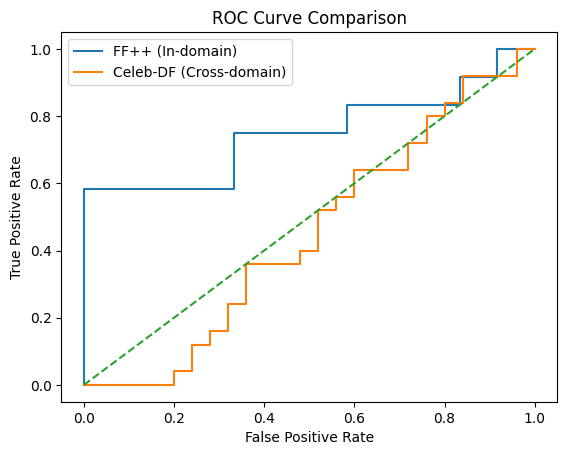

In [99]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def get_probs(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(X_tensor)).cpu().numpy().flatten()
    return probs

# FF++ ROC
probs_in = get_probs(classifier, X_test)
fpr_in, tpr_in, _ = roc_curve(y_test, probs_in)

# Celeb ROC
probs_c = get_probs(classifier, X_celeb)
fpr_c, tpr_c, _ = roc_curve(y_celeb, probs_c)

plt.figure()
plt.plot(fpr_in, tpr_in, label="FF++ (In-domain)")
plt.plot(fpr_c, tpr_c, label="Celeb-DF (Cross-domain)")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [127]:
from sklearn.metrics import confusion_matrix

probs = get_probs(classifier, X_test)
preds = (probs > 0.5).astype(int)

print("Predicted distribution:", np.bincount(preds))
print("True distribution:", np.bincount(y_test))
print("Confusion matrix:\n", confusion_matrix(y_test, preds))


Predicted distribution: [17  7]
True distribution: [12 12]
Confusion matrix:
 [[11  1]
 [ 6  6]]


In [128]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0

for t in np.linspace(0.1, 0.9, 50):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best threshold:", best_thresh)
print("Best F1:", best_f1)


Best threshold: 0.2469387755102041
Best F1: 0.7272727272727273


In [129]:
print("Train distribution:", np.bincount(y_train))
print("Test distribution:", np.bincount(y_test))


Train distribution: [48 48]
Test distribution: [12 12]


In [ ]:
# ===================================================================================

# Phase 4

In [158]:
# =========================================
# PHASE 4 — Load Tasks + Embeddings
# Prepares filtered task dictionary using
# only videos that have valid embeddings
# =========================================

import json
import numpy as np
from pathlib import Path

PHASE1_ROOT = Path("/content/phase1_tasks/ffpp")
EMBED_ROOT = Path("/content/data/processed/embeddings/ffpp")

# ---- Load Phase 1 task definitions ----
with open(PHASE1_ROOT / "meta_train_tasks.json") as f:
    train_tasks = json.load(f)

# ---- Load embeddings from Phase 2 ----
embedding_dict = {}

for task_name in train_tasks.keys():
    task_dir = EMBED_ROOT / task_name

    if not task_dir.exists():
        continue

    meta_path = task_dir / "meta.json"
    if not meta_path.exists():
        continue

    with open(meta_path) as f:
        meta = json.load(f)

    for fname in meta.keys():
        emb_path = task_dir / fname
        if emb_path.exists():
            vid = fname.replace(".npy", "")
            embedding_dict[vid] = np.load(emb_path)

print("Total embeddings loaded:", len(embedding_dict))

# ---- Filter tasks to only include videos with embeddings ----
filtered_tasks = {}

for task_name, videos in train_tasks.items():
    valid_videos = []

    for v in videos:
        vid = Path(v["video_path"]).stem
        if vid in embedding_dict:
            valid_videos.append(v)

    if len(valid_videos) > 0:
        filtered_tasks[task_name] = valid_videos

print("\nFiltered task sizes:")
for t, vids in filtered_tasks.items():
    print(t, "→", len(vids))


Total embeddings loaded: 80

Filtered task sizes:
FFPP_original → 60
FFPP_DeepFakeDetection → 10
FFPP_Deepfakes → 10
FFPP_Face2Face → 10
FFPP_FaceShifter → 10
FFPP_FaceSwap → 10
FFPP_NeuralTextures → 10


In [159]:
# =========================================
# PHASE 4 — Few-Shot Episode Sampler
# Constructs N=2 way K-shot episodes
# Real from FFPP_original
# Fake from one manipulation task
# =========================================

import random
import numpy as np

def sample_episode(tasks, embedding_dict, K=1, Q=5):
    """
    Returns:
        support_x: shape [2K, 512]
        support_y: shape [2K]
        query_x:   shape [2Q, 512]
        query_y:   shape [2Q]
        task_name: selected fake manipulation
    """

    # Select a fake manipulation task
    fake_tasks = [t for t in tasks.keys() if t != "FFPP_original"]
    task_name = random.choice(fake_tasks)

    real_pool = tasks["FFPP_original"]
    fake_pool = tasks[task_name]

    # Ensure sufficient samples exist
    if len(real_pool) < K + Q or len(fake_pool) < K + Q:
        return None

    real_sample = random.sample(real_pool, K + Q)
    fake_sample = random.sample(fake_pool, K + Q)

    support_real = real_sample[:K]
    query_real   = real_sample[K:]

    support_fake = fake_sample[:K]
    query_fake   = fake_sample[K:]

    support_x, support_y = [], []
    query_x, query_y = [], []

    # ---- Build Support Set ----
    for v in support_real:
        vid = Path(v["video_path"]).stem
        support_x.append(embedding_dict[vid])
        support_y.append(0)  # real

    for v in support_fake:
        vid = Path(v["video_path"]).stem
        support_x.append(embedding_dict[vid])
        support_y.append(1)  # fake

    # ---- Build Query Set ----
    for v in query_real:
        vid = Path(v["video_path"]).stem
        query_x.append(embedding_dict[vid])
        query_y.append(0)

    for v in query_fake:
        vid = Path(v["video_path"]).stem
        query_x.append(embedding_dict[vid])
        query_y.append(1)

    return {
        "support_x": np.array(support_x),
        "support_y": np.array(support_y),
        "query_x": np.array(query_x),
        "query_y": np.array(query_y),
        "task_name": task_name
    }


In [162]:
# =========================================
# PHASE 4 — Episode Generator
# Dynamically generates multiple episodes
# for meta-learning training
# =========================================

def generate_episodes(tasks, embedding_dict, K=1, Q=5, num_episodes=100):
    episodes = []

    while len(episodes) < num_episodes:
        ep = sample_episode(tasks, embedding_dict, K, Q)
        if ep is not None:
            episodes.append(ep)

    return episodes


# ---- Example test ----
episodes = generate_episodes(filtered_tasks, embedding_dict,
                             K=1,
                             Q=5,
                             num_episodes=5)

print("Generated episodes:", len(episodes))
print("Support shape:", episodes[0]["support_x"].shape)
print("Query shape:", episodes[0]["query_x"].shape)
print("Task:", episodes[0]["task_name"])


Generated episodes: 5
Support shape: (2, 512)
Query shape: (10, 512)
Task: FFPP_Face2Face
